# TP1: Metodología Box-Jenkins y Suavizado Exponencial ETS

# 1. Configuración inicial y carga de datos

### 1.1 Instalación y carga de librerías

In [125]:
# Instalar paquetes si no están disponibles
# if(!require(readxl)) install.packages("readxl")
# if(!require(forecast)) install.packages("forecast")
# if(!require(tseries)) install.packages("tseries")
# if(!require(ggplot2)) install.packages("ggplot2")
# if(!require(dplyr)) install.packages("dplyr")
# if(!require(zoo)) install.packages("zoo")
# if(!require(lubridate)) install.packages("lubridate")

# Cargar librerías necesarias
library(readxl)
library(forecast)
library(tseries)
library(ggplot2)
library(dplyr)
library(zoo)
library(lubridate)

# Definir ruta del proyecto
project_path <- "C:/Users/trico/OneDrive/UBA/Series de tiempo/TP1"

# 2.1) Cargar función de diagnóstico de residuos
source(file.path(project_path, "corr_res.R"))

# Configurar opciones
options(scipen = 999) # Evitar notación científica
par(bg = "white") # Fondo blanco para gráficos base


### 1.2 Lectura de datos

In [126]:
# Leer datos de Argentina (skip=1 para eliminar sólo el título)
datos_arg <- read_excel(
  file.path(project_path, "Datos Argentina.xlsx"),
  skip      = 1,
  col_names = c("Periodo", "EMAE", "IPC", "M2N", "M2R", "TASA")
)

# Leer datos de Chile (skip=3 para saltar título, línea en blanco y cabecera)
datos_chi <- read_excel(
  file.path(project_path, "Datos Chile.xlsx"),
  skip      = 3,
  col_names = c("Periodo", "IMACEC", "M2N", "IPC", "M2R", "TASA")
)

# Mostrar primeras filas para verificar
head(datos_arg, 5)
head(datos_chi, 5)


Periodo,EMAE,IPC,M2N,M2R,TASA
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2004M01,98.44894,77.33982,66006023,66006023,4.57
2004M02,98.17701,77.18623,67545780,67680182,4.03
2004M03,97.80754,77.32858,68027349,68037235,3.69
2004M04,95.04287,77.62270,70499728,70242804,3.48
2004M05,96.89273,77.75169,72987490,72600858,3.54


Periodo,IMACEC,M2N,IPC,M2R,TASA
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2004-01-01,56.95508,22880.17,46.12519,22880.17,6.107525
2004-02-01,54.85665,22853.76,46.12926,22851.74,6.407674
2004-03-01,61.86300,23231.16,46.32336,23131.78,6.943765
2004-04-01,60.63709,23852.51,46.49362,23663.49,6.637812
2004-05-01,60.08506,23705.82,46.73653,23395.73,6.957272


# 2. Preparación de series temporales



### 2.1 Creación de series temporales y diferencias logarítmicas

In [127]:
datos_arg$Fecha <- as.Date(as.yearmon(gsub("M", "-", datos_arg$Periodo), "%Y-%m"))
datos_chi$Fecha <- as.Date(as.numeric(datos_chi$Periodo), origin = "1899-12-30")

# Crear objetos ts (enero-2004 en adelante)
ts_emae <- ts(datos_arg$EMAE, start = c(2004, 1), frequency = 12)
ts_ipc_arg <- ts(datos_arg$IPC, start = c(2004, 1), frequency = 12)
ts_m2_arg <- ts(datos_arg$M2N, start = c(2004, 1), frequency = 12)
ts_tasa_arg <- ts(datos_arg$TASA, start = c(2004, 1), frequency = 12)

ts_imacec <- ts(datos_chi$IMACEC, start = c(2004, 1), frequency = 12)
ts_ipc_chi <- ts(datos_chi$IPC, start = c(2004, 1), frequency = 12)
ts_m2_chi <- ts(datos_chi$M2N, start = c(2004, 1), frequency = 12)
ts_tasa_chi <- ts(datos_chi$TASA, start = c(2004, 1), frequency = 12)


In [128]:
# Calcular diferencias logarítmicas de cada serie temporal previamente creada

# Función para calcular la diferencia logarítmica
# (aproxima la tasa de crecimiento)
calcular_diff_log <- function(x) diff(log(x))

# --- Series de Argentina ---
# Dif. log EMAE (Act. Económica) Arg
dl_emae <- calcular_diff_log(ts_emae)
# Dif. log IPC (Precios) Arg
dl_ipc_arg <- calcular_diff_log(ts_ipc_arg)
# Dif. log M2 (Agregado Monetario) Arg
dl_m2_arg <- calcular_diff_log(ts_m2_arg)
# Dif. log TASA (Interés) Arg
dl_tasa_arg <- calcular_diff_log(ts_tasa_arg)

# --- Series de Chile ---
# Dif. log IMACEC (Act. Económica) Chi
dl_imacec <- calcular_diff_log(ts_imacec)
# Dif. log IPC (Precios) Chi
dl_ipc_chi <- calcular_diff_log(ts_ipc_chi)
# Dif. log M2 (Agregado Monetario) Chi
dl_m2_chi <- calcular_diff_log(ts_m2_chi)
# Dif. log TASA (Interés) Chi
dl_tasa_chi <- calcular_diff_log(ts_tasa_chi)

# Definir ventanas de entrenamiento para cada serie diferenciada
# Período de entrenamiento: hasta diciembre 2022

# --- Ventanas de Entrenamiento - Argentina ---
# EMAE Arg (entrenamiento)
dl_emae_train <- window(dl_emae, end = c(2022, 12))
# IPC Arg (entrenamiento)
dl_ipc_arg_train <- window(dl_ipc_arg, end = c(2022, 12))
# M2 Arg (entrenamiento)
dl_m2_arg_train <- window(dl_m2_arg, end = c(2022, 12))
# TASA Arg (entrenamiento)
dl_tasa_arg_train <- window(dl_tasa_arg, end = c(2022, 12))

# --- Ventanas de Entrenamiento - Chile ---
# IMACEC Chi (entrenamiento)
dl_imacec_train <- window(dl_imacec, end = c(2022, 12))
# IPC Chi (entrenamiento)
dl_ipc_chi_train <- window(dl_ipc_chi, end = c(2022, 12))
# M2 Chi (entrenamiento)
dl_m2_chi_train <- window(dl_m2_chi, end = c(2022, 12))
# TASA Chi (entrenamiento)
dl_tasa_chi_train <- window(dl_tasa_chi, end = c(2022, 12))


# 3. Estimacion de modelos

## Argentina

### 3.1 Estimacion EMAE - Arg

In [129]:
p_emae <- 4
d_emae <- 0
q_emae <- 0
P_emae <- 0
D_emae <- 1
Q_emae <- 1

model_emae_arg <- Arima( # Sobrescribe la variable original
  dl_emae_train,
  order = c(p_emae, d_emae, q_emae),
  seasonal = list(order = c(P_emae, D_emae, Q_emae), period = 12),
  method = "ML" # Usar Máxima Verosimilitud (o CSS-ML si ML falla)
)

summary(model_emae_arg)

corr_res(
  model_emae_arg,
  lags = 26,
  p_q = p_emae + q_emae + P_emae + Q_emae
)


Series: dl_emae_train 
ARIMA(4,0,0)(0,1,1)[12] 

Coefficients:
         ar1      ar2     ar3     ar4     sma1
      0.1087  -0.1193  0.0291  0.0151  -0.9549
s.e.  0.0681   0.0683  0.0684  0.0682   0.1140

sigma^2 = 0.0003779:  log likelihood = 531.23
AIC=-1050.45   AICc=-1050.05   BIC=-1030.23

Training set error measures:
                       ME       RMSE        MAE      MPE    MAPE     MASE
Training set -0.001823165 0.01869647 0.01109177 97.38346 245.977 0.651687
                    ACF1
Training set -0.01225977

lag,Estadistico Q,p-value
1,0.0346,NA
2,0.061,NA
3,0.1154,NA
4,0.1463,NA
5,0.3813,NA
6,1.2043,0.2725
7,2.1663,0.3385
8,2.2652,0.5192
9,5.9686,0.2015
10,6.6301,0.2496


### 3.2 Estimacion IPC - Arg

In [130]:
# Volviendo al modelo básico pero con mayor complejidad AR
p_ipc <- 3
d_ipc <- 0
q_ipc <- 0
P_ipc <- 0
D_ipc <- 1
Q_ipc <- 1

model_ipc_arg <- Arima(
  dl_ipc_arg_train,
  order = c(p_ipc, d_ipc, q_ipc),
  seasonal = list(order = c(P_ipc, D_ipc, Q_ipc), period = 12),
  method = "ML"
)

summary(model_ipc_arg)
corr_res(model_ipc_arg,
  lags = 26,
  p_q = p_ipc + q_ipc + P_ipc + Q_ipc
)


Series: dl_ipc_arg_train 
ARIMA(3,0,0)(0,1,1)[12] 

Coefficients:
         ar1     ar2     ar3     sma1
      0.3718  0.2894  0.1128  -0.8476
s.e.  0.0683  0.0717  0.0693   0.0610

sigma^2 = 0.0001413:  log likelihood = 642.08
AIC=-1274.17   AICc=-1273.88   BIC=-1257.32

Training set error measures:
                     ME       RMSE         MAE       MPE     MAPE      MASE
Training set 0.00182997 0.01145982 0.008247476 -70.32671 114.9075 0.6116113
                    ACF1
Training set -0.03025047

lag,Estadistico Q,p-value
1,0.2105,NA
2,0.4043,NA
3,0.5278,NA
4,0.8899,NA
5,3.8074,0.051
6,3.8653,0.1448
7,4.0211,0.2592
8,6.6917,0.1531
9,7.6487,0.1767
10,8.5062,0.2033


### 3.3 Estimacion Agregado Monetario M2 - Arg

In [131]:
model_m2_arg <- Arima(
  dl_m2_arg_train,
  order    = c(1, 0, 4), # MA(4) añadido
  seasonal = list(order = c(0, 1, 1), period = 12),
  method   = "ML",
)

summary(model_m2_arg)

# Diagnóstico residuos
corr_res(model_m2_arg,
  lags = 26,
  p_q  = 1 + 4 + 0 + 1
) # 1 AR + 4 MA + 1 SMA


Series: dl_m2_arg_train 
ARIMA(1,0,4)(0,1,1)[12] 

Coefficients:
          ar1     ma1     ma2     ma3     ma4     sma1
      -0.6257  0.5542  0.0122  0.2789  0.3190  -0.7056
s.e.   0.2159  0.2109  0.0775  0.0714  0.0665   0.0814

sigma^2 = 0.0007509:  log likelihood = 466.94
AIC=-919.89   AICc=-919.35   BIC=-896.29

Training set error measures:
                      ME       RMSE        MAE      MPE     MAPE      MASE
Training set 0.002100576 0.02629295 0.01895284 12.85338 117.0499 0.7867427
                     ACF1
Training set -0.003363185

lag,Estadistico Q,p-value
1,0.0026,NA
2,0.0104,NA
3,0.0592,NA
4,0.0604,NA
5,0.1509,NA
6,0.3754,NA
7,1.1366,0.2864
8,1.2256,0.5418
9,1.4537,0.693
10,4.5406,0.3378


### 3.4 Estimacion Tasa de interes - Arg

In [132]:
# Especificar órdenes del modelo IMACEC
p_tasa <- 4
d_tasa <- 0
q_tasa <- 0
P_tasa <- 0
D_tasa <- 1
Q_tasa <- 1


model_tasa_arg <- Arima(
  dl_tasa_arg_train,
  order = c(p_tasa, d_tasa, q_tasa),
  seasonal = list(order = c(P_tasa, D_tasa, Q_tasa), period = 12),
  method = "ML" #
)

# Resumen del modelo TASA con estructura forzada
summary(model_tasa_arg)

corr_res(
  model_tasa_arg,
  lags = 26,
  p_q = p_tasa + q_tasa + P_tasa + Q_tasa
)


Series: dl_tasa_arg_train 
ARIMA(4,0,0)(0,1,1)[12] 

Coefficients:
         ar1      ar2     ar3     ar4    sma1
      0.5637  -0.2021  0.0070  0.0732  -1.000
s.e.  0.0681   0.0781  0.0781  0.0682   0.094

sigma^2 = 0.002731:  log likelihood = 314.22
AIC=-616.43   AICc=-616.03   BIC=-596.21

Training set error measures:
                      ME       RMSE        MAE MPE MAPE      MASE         ACF1
Training set 0.001583406 0.05026569 0.03361232 NaN  Inf 0.5223795 -0.005378132

lag,Estadistico Q,p-value
1,0.0067,NA
2,0.0067,NA
3,0.0852,NA
4,0.5813,NA
5,1.5438,NA
6,1.6629,0.1972
7,4.3407,0.1141
8,4.727,0.1929
9,4.8562,0.3024
10,5.2552,0.3855


## Chile

### 3.5 Estimacion IMACEC - Chile

In [133]:
model_imacec_chi <- Arima(
  y = dl_imacec_train,
  order = c(4, 0, 2),
  seasonal = list(order = c(0, 1, 1), period = 12),
  include.drift = FALSE,
  include.mean = TRUE,
  method = "ML"
)

# Resumen del modelo
summary(model_imacec_chi)

# Cálculo del número de parámetros para el test de Ljung-Box
num_arma_params <- sum(model_imacec_chi$arma[c(1, 2, 3, 4)]) # p + q + P + Q
drift_present <- as.integer("drift" %in% names(model_imacec_chi$coef))
grados_libertad_q <- num_arma_params + drift_present

cat(
  "Calculando p_q como:", num_arma_params, "(arma) +", drift_present, "(drift) =",
  grados_libertad_q, "\n"
)

# Diagnóstico de residuos
corr_res(
  xreg = model_imacec_chi,
  lags = 35,
  p_q  = grados_libertad_q
)


Series: dl_imacec_train 
ARIMA(4,0,2)(0,1,1)[12] 

Coefficients:
          ar1      ar2      ar3      ar4     ma1     ma2     sma1
      -0.4197  -0.8794  -0.0076  -0.2577  0.4300  0.8152  -0.7246
s.e.   0.1025   0.1012   0.0763   0.0710  0.0829  0.0808   0.0548

sigma^2 = 0.0002896:  log likelihood = 569.88
AIC=-1123.76   AICc=-1123.06   BIC=-1096.8

Training set error measures:
                        ME       RMSE        MAE       MPE     MAPE      MASE
Training set -0.0007144392 0.01629115 0.01096072 -11.04126 58.97048 0.7717417
                     ACF1
Training set -0.005197869

Calculando p_q como: 7 (arma) + 0 (drift) = 7 


lag,Estadistico Q,p-value
1,0.0062,NA
2,0.027,NA
3,0.0734,NA
4,0.3094,NA
5,0.3115,NA
6,0.5671,NA
7,1.7542,NA
8,1.7653,0.184
9,2.1483,0.3416
10,2.3481,0.5034


### 3.6 Estimacion IPC - Chile

In [134]:
# IPC Chile: Mejora del modelo con enfoque mixto

# TODO: probar desestacionalizacion x-12 con seasonal

# 1. Ajuste manual del modelo considerando componente estacional explícito
model_ipc_chi <- Arima(
  dl_ipc_chi_train,
  order = c(1, 1, 6),           # Simplificar componente ARMA
  seasonal = list(order = c(1, 0, 1), period = 12),  # Agregar componente estacional
  include.mean = TRUE,          # Mantener intercepto
  method = "ML"
)

# 2. Resumen del modelo
summary(model_ipc_chi)

# 3. Verificar correlación en residuos
p_q <- 1 + 1 + 1 + 1  # AR + MA + SAR + SMA
corr_res(model_ipc_chi, lags = 26, p_q = p_q)

Series: dl_ipc_chi_train 
ARIMA(1,1,6)(1,0,1)[12] 

Coefficients:
          ar1     ma1      ma2      ma3      ma4      ma5     ma6    sar1
      -0.7618  0.2913  -0.6911  -0.1194  -0.0546  -0.2244  0.0701  0.9582
s.e.   0.1197  0.1246   0.0854   0.0914   0.1016   0.0683  0.0921  0.0416
         sma1
      -0.8541
s.e.   0.0833

sigma^2 = 0.00001145:  log likelihood = 966.47
AIC=-1912.95   AICc=-1911.92   BIC=-1878.74

Training set error measures:
                       ME        RMSE         MAE  MPE MAPE      MASE
Training set 0.0001498883 0.003308231 0.002546371 -Inf  Inf 0.6731737
                    ACF1
Training set -0.01178935

lag,Estadistico Q,p-value
1,0.032,NA
2,0.0763,NA
3,0.1026,NA
4,0.1908,NA
5,1.6714,0.1961
6,1.7964,0.4073
7,2.618,0.4544
8,3.3066,0.5079
9,3.9353,0.5588
10,7.5232,0.2752


### 3.7 Estimacion Agregado Monetario M2 - Chile

In [135]:

model_m2_chi <- auto.arima(
  dl_m2_chi_train,
  seasonal = TRUE, # Permitir búsqueda estacional (P, Q, D)
  stepwise = TRUE, # Búsqueda por pasos (más rápida)
  approximation = TRUE # Usar aproximaciones (más rápido)
)

summary(model_m2_chi)

corr_res(
  model_m2_chi,
  lags = 26,
  p_q = sum(model_m2_chi$arma[c(1, 2, 3, 4)])
)

Series: dl_m2_chi_train 
ARIMA(0,1,1)(2,0,0)[12] 

Coefficients:
          ma1    sar1    sar2
      -0.9815  0.2641  0.2601
s.e.   0.0138  0.0652  0.0691

sigma^2 = 0.0001661:  log likelihood = 661.44
AIC=-1314.89   AICc=-1314.71   BIC=-1301.2

Training set error measures:
                        ME       RMSE         MAE       MPE     MAPE      MASE
Training set -0.0008344935 0.01277276 0.009992993 -68.85854 285.2192 0.8076566
                   ACF1
Training set 0.04291844

lag,Estadistico Q,p-value
1,0.4237,NA
2,0.651,NA
3,1.6027,NA
4,2.0765,0.1496
5,2.0919,0.3514
6,2.5101,0.4735
7,3.1918,0.5263
8,4.095,0.5358
9,9.4122,0.1517
10,10.1447,0.1805


### 3.8 Estimacion Tasa de interes - Chile

In [136]:
p_tasa_chi <- 4
d_tasa_chi <- 0
q_tasa_chi <- 0
P_tasa_chi <- 0
D_tasa_chi <- 1
Q_tasa_chi <- 1

model_tasa_chi <- Arima( # Sobrescribe la variable original
  dl_tasa_chi_train,
  order = c(p_tasa_chi, d_tasa_chi, q_tasa_chi),
  seasonal = list(order = c(P_tasa_chi, D_tasa_chi, Q_tasa_chi), period = 12),
  method = "ML" # Usar Máxima Verosimilitud (o CSS-ML si ML falla)
)

summary(model_tasa_chi)

corr_res(
  model_tasa_chi,
  lags = 26,
  p_q = p_tasa_chi + q_tasa_chi + P_tasa_chi + Q_tasa_chi
)



Series: dl_tasa_chi_train 
ARIMA(4,0,0)(0,1,1)[12] 

Coefficients:
         ar1     ar2     ar3     ar4     sma1
      0.0504  0.1116  0.1778  0.0537  -0.9398
s.e.  0.0680  0.0675  0.0676  0.0685   0.0953

sigma^2 = 0.004304:  log likelihood = 270.79
AIC=-529.58   AICc=-529.18   BIC=-509.36

Training set error measures:
                       ME     RMSE        MAE      MPE     MAPE      MASE
Training set -0.001051868 0.063102 0.04341471 176.8415 381.1785 0.6787993
                    ACF1
Training set 0.001805859

lag,Estadistico Q,p-value
1,0.0008,NA
2,0.032,NA
3,0.0385,NA
4,0.0812,NA
5,2.2224,NA
6,2.2275,0.1356
7,5.4423,0.0658
8,6.3018,0.0978
9,6.8525,0.1439
10,6.916,0.227


# 4 Pronosticos de Diferencias Logaritmicas

In [137]:
source("plot_forecast_comparison.R")


## Argentina

### 4.1 Proyeccion EMAE - Argentina

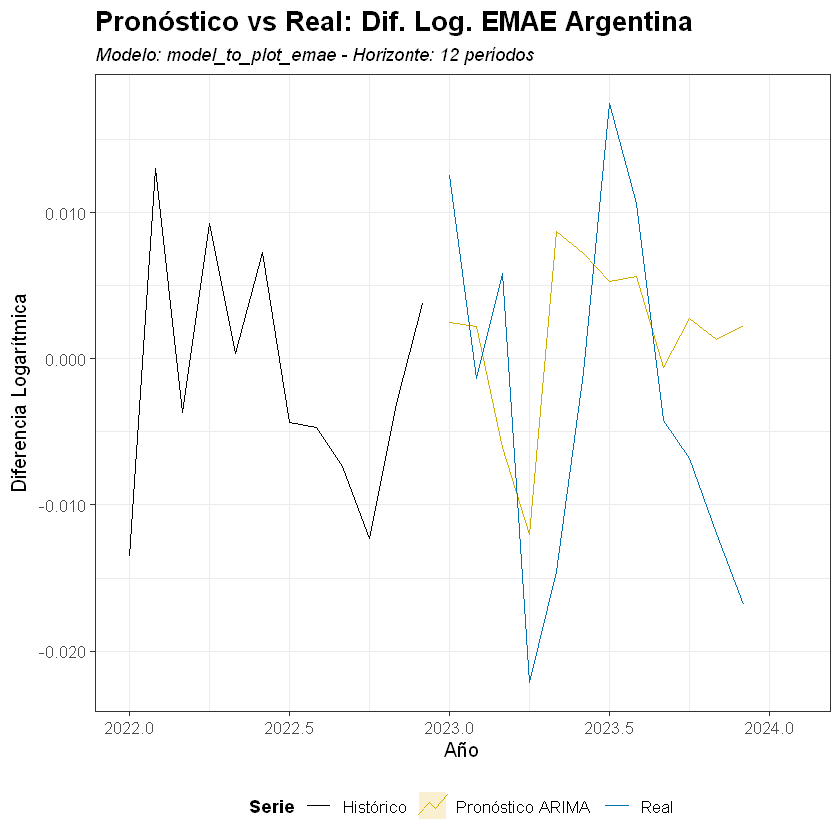

In [138]:
# 2. Definir parámetros para el gráfico
h_forecast_emae <- 12 # Horizonte ya definido
model_to_plot_emae <- model_emae_arg # Modelo ARIMA ajustado (forzado)
original_ts_emae <- dl_emae
title_emae <- "Dif. Log. EMAE Argentina"
start_plot_emae <- 2022 # Año desde donde mostrar histórico
ylabel_emae <- "Diferencia Logarítmica" # Etiqueta eje Y

# 3. Llamar a la función para generar el objeto ggplot
plot_emae_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_emae,
  original_ts = original_ts_emae,
  h = h_forecast_emae,
  series_title = title_emae,
  start_year_plot = start_plot_emae,
  ylab_text = ylabel_emae,
  show_pi = FALSE # No mostrar Intervalos de Predicción por ahora
)

# 4. Mostrar el gráfico generado
print(plot_emae_comparison)


### 4.2 Proyeccion IPC - Argentina

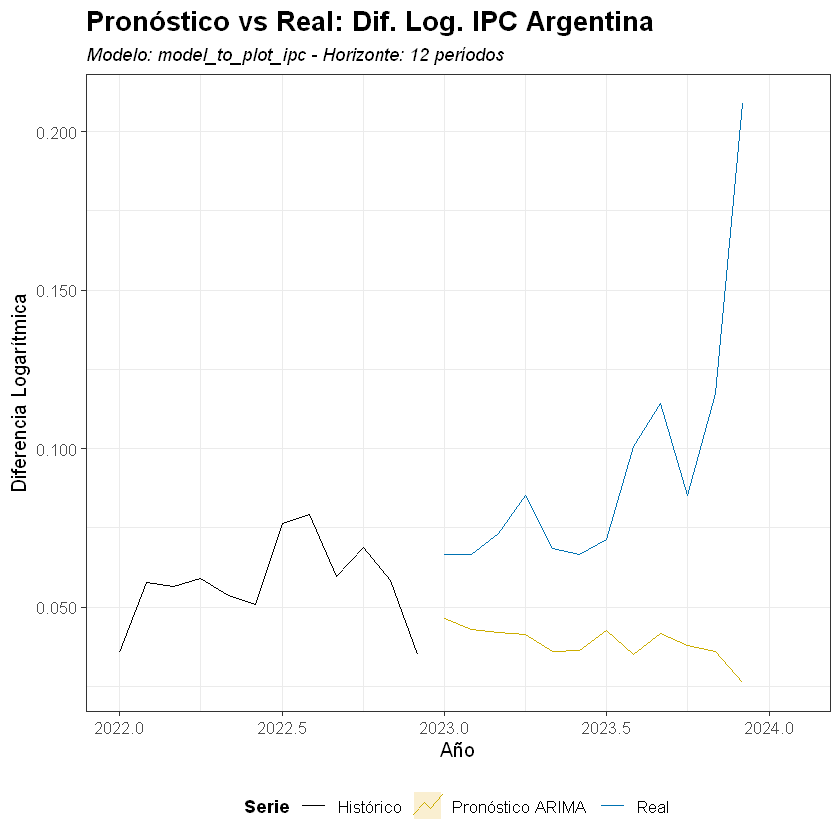

In [139]:
h_forecast_ipc <- 12 # Horizonte
model_to_plot_ipc <- model_ipc_arg # Modelo ARIMA ajustado (forzado o auto.arima)
original_ts_ipc <- dl_ipc_arg # Serie original completa (diferencias log)
title_ipc <- "Dif. Log. IPC Argentina" # Título para el gráfico
start_plot_ipc <- 2022 # Año desde donde mostrar histórico
ylabel_ipc <- "Diferencia Logarítmica" # Etiqueta eje Y

plot_ipc_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_ipc,
  original_ts = original_ts_ipc,
  h = h_forecast_ipc,
  series_title = title_ipc,
  start_year_plot = start_plot_ipc,
  ylab_text = ylabel_ipc,
  show_pi = FALSE # No mostrar Intervalos de Predicción
)

# 4. Mostrar el gráfico generado
print(plot_ipc_comparison)


### 4.3 Proyeccion Agregado Monetario M2 - Argentina

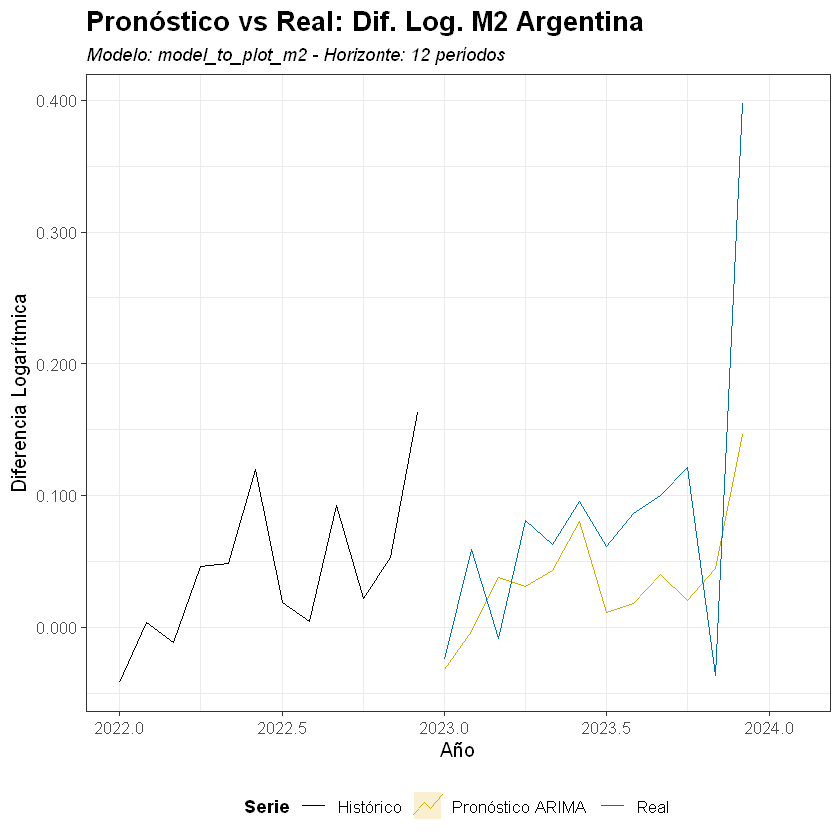

In [140]:
# 2. Definir parámetros específicos para el gráfico del M2
h_forecast_m2 <- 12 # Horizonte
model_to_plot_m2 <- model_m2_arg # Modelo ARIMA ajustado
original_ts_m2 <- dl_m2_arg # Serie original completa (diferencias log)
title_m2 <- "Dif. Log. M2 Argentina" # Título para el gráfico
start_plot_m2 <- 2022 # Año desde donde mostrar histórico
ylabel_m2 <- "Diferencia Logarítmica" # Etiqueta eje Y

# 3. Llamar a la función para generar el objeto ggplot
plot_m2_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_m2,
  original_ts = original_ts_m2,
  h = h_forecast_m2,
  series_title = title_m2,
  start_year_plot = start_plot_m2,
  ylab_text = ylabel_m2,
  show_pi = FALSE # No mostrar Intervalos de Predicción
)

# 4. Mostrar el gráfico generado
print(plot_m2_comparison)


### 4.4 Proyeccion Tasa de interes - Argentina

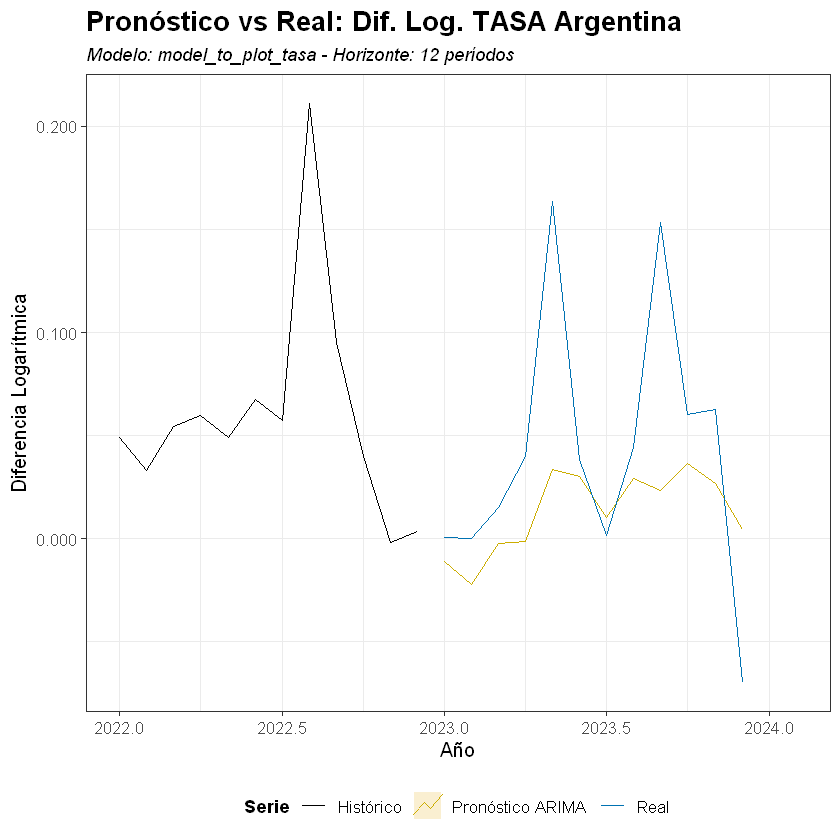

In [141]:
h_forecast_tasa <- 12 # Horizonte
model_to_plot_tasa <- model_tasa_arg # Modelo ARIMA ajustado (forzado o auto.arima)
original_ts_tasa <- dl_tasa_arg # Serie original completa (diferencias log)
title_tasa <- "Dif. Log. TASA Argentina" # Título para el gráfico
start_plot_tasa <- 2022 # Año desde donde mostrar histórico
ylabel_tasa <- "Diferencia Logarítmica" # Etiqueta eje Y

plot_tasa_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_tasa,
  original_ts = original_ts_tasa,
  h = h_forecast_tasa,
  series_title = title_tasa,
  start_year_plot = start_plot_tasa,
  ylab_text = ylabel_tasa,
  show_pi = FALSE # No mostrar Intervalos de Predicción
)

# 4. Mostrar el gráfico generado
print(plot_tasa_comparison)

## Chile

### 4.5 Proyeccion IMACEC - Chile

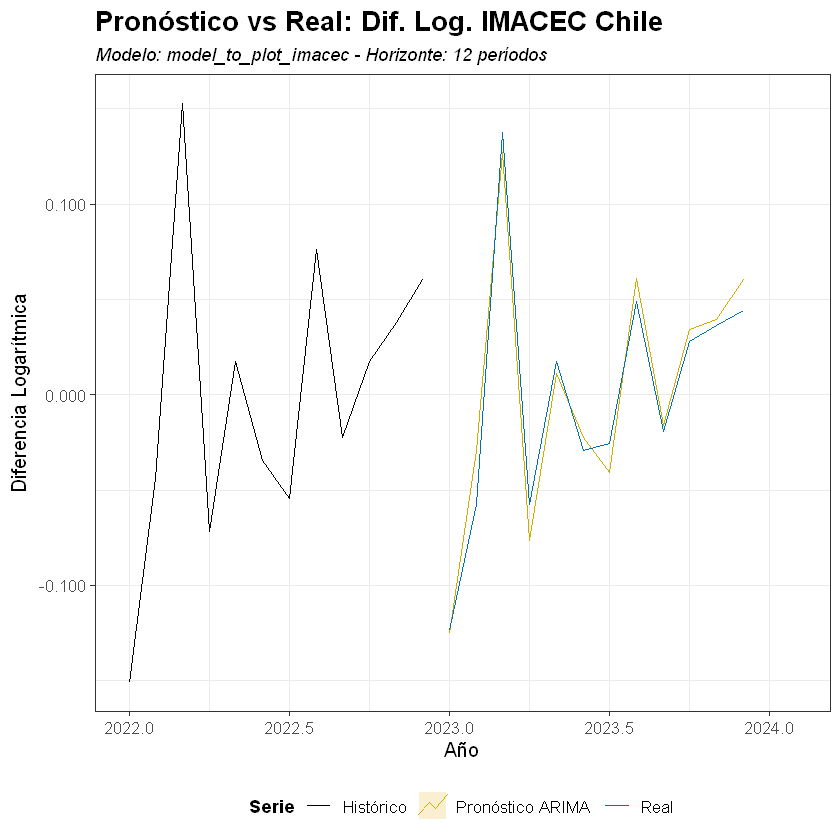

In [142]:
# Modelo ARIMA simplificado sin regresores externos
h_forecast_imacec <- 12
model_to_plot_imacec <- model_imacec_chi
original_ts_imacec <- dl_imacec
title_imacec <- "Dif. Log. IMACEC Chile"
start_plot_imacec <- 2022
ylabel_imacec <- "Diferencia Logarítmica"

# Utilizar la función modular directamente sin complicaciones
plot_imacec_comparison <- plot_forecast_vs_actual(
  model           = model_to_plot_imacec,
  original_ts     = original_ts_imacec,
  h               = h_forecast_imacec,
  series_title    = title_imacec,
  start_year_plot = start_plot_imacec,
  ylab_text       = ylabel_imacec,
  show_pi         = FALSE
)

# Mostrar el gráfico
print(plot_imacec_comparison)


### 4.6 Proyeccion IPC - Chile

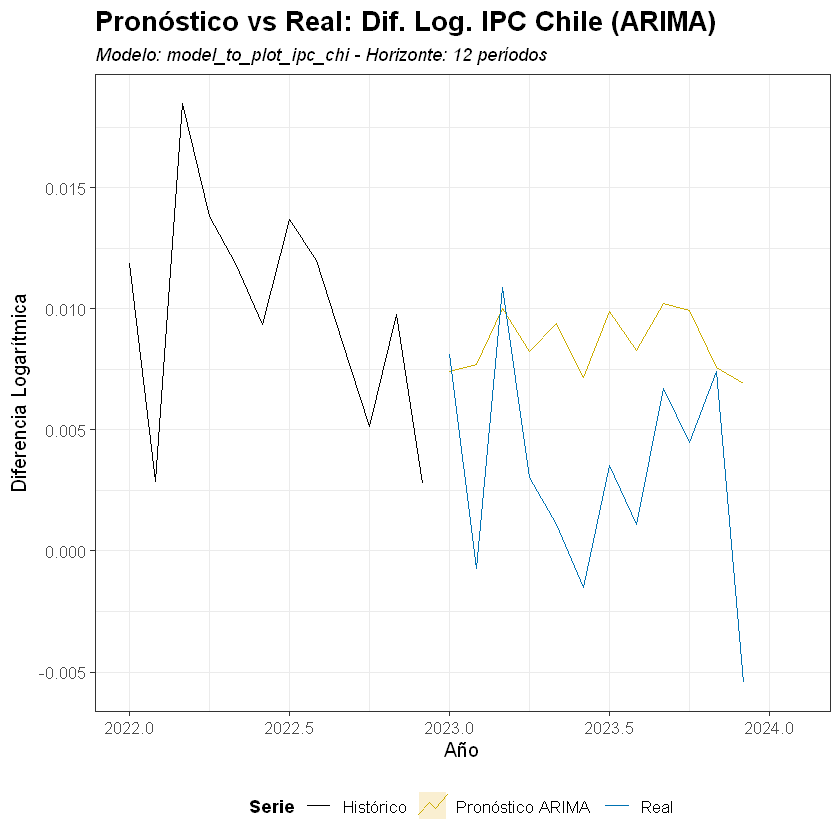

In [143]:
# --- Graficar Pronóstico IPC Chile con modelo ARIMA vs Real usando función modular ---

# 2. Definir parámetros para el gráfico del IPC Chile
h_forecast_ipc_chi <- 12                      # Horizonte
model_to_plot_ipc_chi <- model_ipc_chi        # Usar el nuevo modelo ARIMA
original_ts_ipc_chi <- dl_ipc_chi             # Serie original completa (diferencias log)
title_ipc_chi <- "Dif. Log. IPC Chile (ARIMA)"  # Actualizar título
start_plot_ipc_chi <- 2022                    # Año desde donde mostrar histórico
ylabel_ipc_chi <- "Diferencia Logarítmica"    # Etiqueta eje Y

# 3. Llamar a la función para generar el objeto ggplot
# No necesitamos xreg ya que el nuevo modelo no usa regresores externos
plot_ipc_chi_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_ipc_chi,
  original_ts = original_ts_ipc_chi,
  h = h_forecast_ipc_chi,
  series_title = title_ipc_chi,
  start_year_plot = start_plot_ipc_chi,
  ylab_text = ylabel_ipc_chi,
  show_pi = FALSE  # No mostrar Intervalos de Predicción
)

# 4. Mostrar el gráfico generado
print(plot_ipc_chi_comparison)

### 4.6 Proyeccion Agregado Monetario M2 - Chile

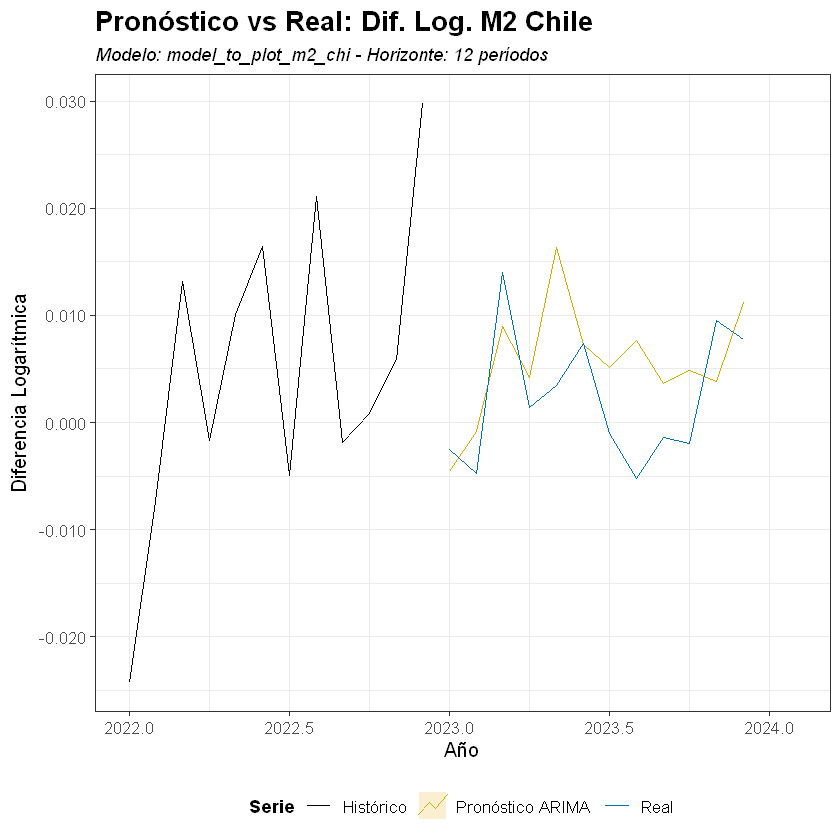

In [144]:
# --- Graficar Pronóstico M2 Chile vs Real usando función modular ---

# 1. Cargar la función desde el script R (si no se ha hecho antes)
# source("plot_forecast_comparison.R")

# 2. Definir parámetros específicos para el gráfico del M2 Chile
h_forecast_m2_chi <- 12 # Horizonte (asumido)
model_to_plot_m2_chi <- model_m2_chi # Modelo ARIMA ajustado
original_ts_m2_chi <- dl_m2_chi # Serie original completa (diferencias log)
title_m2_chi <- "Dif. Log. M2 Chile" # Título para el gráfico
start_plot_m2_chi <- 2022 # Año desde donde mostrar histórico
ylabel_m2_chi <- "Diferencia Logarítmica" # Etiqueta eje Y

# 3. Llamar a la función para generar el objeto ggplot
plot_m2_chi_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_m2_chi,
  original_ts = original_ts_m2_chi,
  h = h_forecast_m2_chi,
  series_title = title_m2_chi,
  start_year_plot = start_plot_m2_chi,
  ylab_text = ylabel_m2_chi,
  show_pi = FALSE # No mostrar Intervalos de Predicción
)

# 4. Mostrar el gráfico generado
print(plot_m2_chi_comparison)

# 5. (Opcional) Guardar el gráfico con dimensiones y resolución específicas
# DESCOMENTA para guardar la imagen.
# dir.create("graficos", showWarnings = FALSE)
# ggsave(
#   filename = "graficos/pronostico_m2_chi_comparacion.png", # Nombre de archivo
#   plot = plot_m2_chi_comparison,
#   width = 10,  # Ancho
#   height = 6,  # Alto
#   dpi = 300    # Resolución
# )
# print("Gráfico guardado en graficos/pronostico_m2_chi_comparacion.png")


### 4.7 Proyeccion Diferencia Logaritmica de Tasa de Interes - Chile

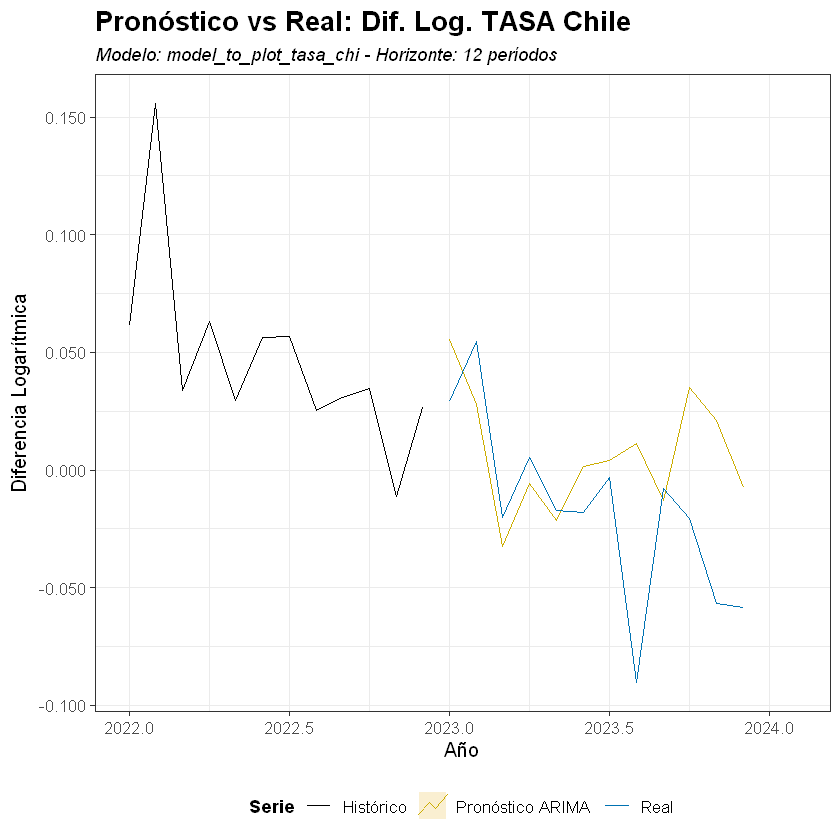

In [145]:
# --- Graficar Pronóstico TASA Chile vs Real usando función modular ---

# 1. Cargar la función desde el script R (si no se ha hecho antes)
# source("plot_forecast_comparison.R")

# 2. Definir parámetros específicos para el gráfico de la TASA Chile
h_forecast_tasa_chi <- 12 # Horizonte
model_to_plot_tasa_chi <- model_tasa_chi # Modelo ARIMA ajustado (forzado o auto.arima)
original_ts_tasa_chi <- dl_tasa_chi # Serie original completa (diferencias log)
title_tasa_chi <- "Dif. Log. TASA Chile" # Título para el gráfico
start_plot_tasa_chi <- 2022 # Año desde donde mostrar histórico
ylabel_tasa_chi <- "Diferencia Logarítmica" # Etiqueta eje Y

# 3. Llamar a la función para generar el objeto ggplot
# Se usa el modelo actual 'model_tasa_chi'. No se pasa xreg.
plot_tasa_chi_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_tasa_chi,
  original_ts = original_ts_tasa_chi,
  h = h_forecast_tasa_chi,
  series_title = title_tasa_chi,
  start_year_plot = start_plot_tasa_chi,
  ylab_text = ylabel_tasa_chi,
  show_pi = FALSE # No mostrar Intervalos de Predicción
)

# 4. Mostrar el gráfico generado
print(plot_tasa_chi_comparison)

# 5. (Opcional) Guardar el gráfico con dimensiones y resolución específicas
# DESCOMENTA para guardar la imagen.
# dir.create("graficos", showWarnings = FALSE)
# ggsave(
#   filename = "graficos/pronostico_tasa_chi_comparacion.png", # Nombre de archivo
#   plot = plot_tasa_chi_comparison,
#   width = 10,  # Ancho
#   height = 6,  # Alto
#   dpi = 300    # Resolución
# )
# print("Gráfico guardado en graficos/pronostico_tasa_chi_comparacion.png")


# 5 - Comparacion y evaluacion de proyecciones

In [146]:
# Cargar eval_pron.R
source("eval_pron.R")


In [147]:
# --- Retransformación con corrección de Jensen (con manejo de longitudes) ---
retransform_diflog <- function(fc, last_level) {
  # Convertir a valor escalar (número)
  last_log_value <- as.numeric(log(last_level))
  cum_log <- cumsum(fc$mean)

  # Crear vector de resultados
  h <- length(cum_log)
  forecast_levels <- numeric(h)

  # Cálculo manual para cada horizonte
  for (i in 1:h) {
    # Con o sin corrección de Jensen según disponibilidad
    if (!is.null(fc$se) && is.numeric(fc$se)) {
      sigma2 <- (fc$se[i])^2
      forecast_levels[i] <- exp(last_log_value + cum_log[i] + 0.5 * sigma2)
    } else {
      # Sin corrección de Jensen
      forecast_levels[i] <- exp(last_log_value + cum_log[i])
    }
  }

  # Convertir a objeto ts con la misma frecuencia y fecha de inicio que el pronóstico
  start_fc <- start(fc$mean)
  freq_fc <- frequency(fc$mean)
  return(ts(forecast_levels, start = start_fc, frequency = freq_fc))
}


## 5.1 Comparacion y evaluacion de modelos argentinos

In [148]:
# --- Evaluación de Pronósticos ARGENTINA en Niveles (2023) ---

# 2. Definir horizonte y período de evaluación (común)
h_eval <- 12
start_eval <- c(2023, 1)
end_eval <- c(2023, 12)

# 3. Lista para almacenar los resultados de evaluación de Argentina
results_list_arg <- list()

# --- Procesamiento y Evaluación Series ARGENTINAS ---

# Configuración solo para Argentina
series_config_arg <- list(
  list(name = "EMAE Arg", model = model_emae_arg, original_ts = ts_emae, xreg = NULL),
  list(name = "IPC Arg", model = model_ipc_arg, original_ts = ts_ipc_arg, xreg = NULL),
  list(name = "M2 Arg", model = model_m2_arg, original_ts = ts_m2_arg, xreg = NULL),
  list(name = "TASA Arg", model = model_tasa_arg, original_ts = ts_tasa_arg, xreg = NULL)
)

# Bucle para series argentinas
for (cfg in series_config_arg) {
  cat("Procesando ARG:", cfg$name, "\n")

  # Generar pronóstico de diferencias logarítmicas
  fc_diflog <- tryCatch(
    {
      forecast(cfg$model, h = h_eval) # No se necesita xreg para Arg
    },
    error = function(e) {
      warning(paste("Error al pronosticar para", cfg$name, ":", e$message))
      return(NULL)
    }
  )
  if (is.null(fc_diflog)) next

  # Obtener último valor observado de 2022 para retransformación
  last_obs_2022 <- tail(window(cfg$original_ts, end = c(2022, 12)), 1)

  # Retransformar a niveles usando la función común
  fc_levels <- retransform_diflog(fc_diflog, last_obs_2022)

  # Obtener valores reales en niveles
  actual_levels <- window(cfg$original_ts, start = start_eval, end = end_eval)

  # Preparar vectores y validar longitudes
  Y_P <- as.vector(fc_levels)
  Y_A <- as.vector(actual_levels)
  if (length(Y_A) == 0) {
    warning(paste("No hay datos reales para", cfg$name))
    next
  }
  min_len <- min(length(Y_P), length(Y_A))
  if (min_len < h_eval) {
    warning(paste("Datos incompletos en", cfg$name))
  }
  Y_P <- Y_P[1:min_len]
  Y_A <- Y_A[1:min_len]

  # Evaluar
  evaluation_metrics <- tryCatch(
    {
      Eval_Pron(Y_P = Y_P, Y_A = Y_A, Nombre = cfg$name)
    },
    error = function(e) {
      warning(paste("Error en Eval_Pron para", cfg$name, ":", e$message))
      return(NULL)
    }
  )
  if (is.null(evaluation_metrics)) next

  results_list_arg[[cfg$name]] <- evaluation_metrics
  cat("Evaluación ARG completada para:", cfg$name, "\n\n")
}

# Consolidar y mostrar resultados de Argentina
if (length(results_list_arg) > 0) {
  final_results_table_arg <- do.call(cbind, results_list_arg)
  print("--- Tabla Evaluación ARGENTINA (Niveles 2023) ---")
  print(round(final_results_table_arg, 4))
} else {
  print("No se generaron resultados para Argentina.")
}


Procesando ARG: EMAE Arg 
Evaluación ARG completada para: EMAE Arg 

Procesando ARG: IPC Arg 
Evaluación ARG completada para: IPC Arg 

Procesando ARG: M2 Arg 
Evaluación ARG completada para: M2 Arg 

Procesando ARG: TASA Arg 
Evaluación ARG completada para: TASA Arg 

[1] "--- Tabla Evaluación ARGENTINA (Niveles 2023) ---"
             EMAE Arg   IPC Arg          M2 Arg TASA Arg
RMSE           3.1958 7873.3844 5732754227.2541  25.8595
MAE            2.5997 5704.4467 3936500541.1410  21.0132
MAPE           1.7793   20.5973         16.5435  18.9541
U_Theil        0.0108    0.1915          0.1608   0.1443
U_sesgo        0.2278    0.5249          0.4715   0.6603
U_varianza     0.0571    0.4533          0.5089   0.3301
U_covarianza   0.7151    0.0218          0.0196   0.0096


## 5.2 Comparacion y evaluacion de modelos chilenos


In [149]:
# -----------------------------------------------------------------
# Evaluación de Pronósticos CHILE en Niveles (2023)
library(forecast)
library(lubridate)

if (!exists("Eval_Pron")) stop("Función Eval_Pron no encontrada.")

results_list_chi <- list()
if (!exists("h_eval")) h_eval <- 12
if (!exists("start_eval")) start_eval <- c(2023, 1)
if (!exists("end_eval")) end_eval <- c(2023, 12)

series_config_chi <- list(
  list(name = "IMACEC Chi", model = model_imacec_chi, original_ts = ts_imacec, needs_xreg_future = FALSE),
  list(name = "IPC Chi", model = model_ipc_chi, original_ts = ts_ipc_chi, needs_xreg_future = TRUE),
  list(name = "M2 Chi", model = model_m2_chi, original_ts = ts_m2_chi, needs_xreg_future = FALSE),
  list(name = "TASA Chi", model = model_tasa_chi, original_ts = ts_tasa_chi, needs_xreg_future = FALSE)
)

for (cfg in series_config_chi) {
  cat("Procesando Evaluación para:", cfg$name, "...\n")
  xreg_future <- NULL
  if (cfg$needs_xreg_future && cfg$name == "IPC Chi") {
    future_ts <- ts(1:h_eval, start = start_eval, frequency = 12)
    future_mes <- factor(cycle(future_ts), levels = 1:12)
    xreg_future <- model.matrix(~future_mes)[, -1]
  }

  fc_diflog <- tryCatch(
    {
      if (cfg$needs_xreg_future) {
        forecast(cfg$model, h = h_eval, xreg = xreg_future)
      } else {
        forecast(cfg$model, h = h_eval)
      }
    },
    error = function(e) {
      warning(e$message)
      return(NULL)
    }
  )
  if (is.null(fc_diflog)) next

  last_obs_2022 <- tail(window(cfg$original_ts, end = c(2022, 12)), 1)
  fc_levels <- retransform_diflog(fc_diflog, last_obs_2022)

  actual_levels <- window(cfg$original_ts, start = start_eval, end = end_eval)
  Y_P <- as.vector(fc_levels)
  Y_A <- as.vector(actual_levels)

  min_len <- min(length(Y_P), length(Y_A))
  if (min_len < h_eval) warning(paste(cfg$name, ": horizonte reducido a", min_len))
  Y_P <- Y_P[1:min_len]
  Y_A <- Y_A[1:min_len]

  eval_metrics <- tryCatch(
    {
      Eval_Pron(Y_P = Y_P, Y_A = Y_A, Nombre = cfg$name)
    },
    error = function(e) {
      warning(e$message)
      return(NULL)
    }
  )
  if (is.null(eval_metrics)) next

  results_list_chi[[cfg$name]] <- eval_metrics
  cat(" -> Evaluación completada.\n")
}

if (length(results_list_chi) > 0) {
  tabla_chi <- do.call(cbind, results_list_chi)
  cat("\n--- Tabla Evaluación CHILE (Niveles 2023) ---\n")
  print(round(tabla_chi, 4))
} else {
  cat("No se generaron resultados de evaluación para Chile.\n")
}


Procesando Evaluación para: IMACEC Chi ...
 -> Evaluación completada.
Procesando Evaluación para: IPC Chi ...


Warning message in forecast.forecast_ARIMA(cfg$model, h = h_eval, xreg = xreg_future):
"xreg not required by this model, ignoring the provided regressors"


 -> Evaluación completada.
Procesando Evaluación para: M2 Chi ...
 -> Evaluación completada.
Procesando Evaluación para: TASA Chi ...
 -> Evaluación completada.

--- Tabla Evaluación CHILE (Niveles 2023) ---
             IMACEC Chi IPC Chi    M2 Chi TASA Chi
RMSE             1.4311  3.7765 4697.1157   1.7707
MAE              1.0686  3.1432 3652.0657   1.1843
MAPE             0.9858  3.1330    2.0335   8.7087
U_Theil          0.0066  0.0186    0.0130   0.0567
U_sesgo          0.0868  0.6879    0.5504   0.3112
U_varianza       0.2070  0.2942    0.3404   0.2945
U_covarianza     0.7061  0.0179    0.1092   0.3943


# 6. Comparación con Suavizado Exponencial (ETS) sin Tendencia

## 6.1 Comparacion ETS Argentina

In [150]:
# --- Ajuste, Pronóstico y Evaluación ARGENTINA con ETS (Sin Tendencia) ---

# 1. Cargar paquetes y funciones necesarias (si no están cargados)
# library(forecast)
# source("eval_pron.R") # Asegurarse que Eval_Pron esté disponible

# 2. Definir períodos y horizonte
end_train_ets <- c(2022, 12)
start_eval_ets <- c(2023, 1)
end_eval_ets <- c(2023, 12)
h_ets <- 12

# 3. Lista para almacenar resultados de evaluación ETS para Argentina
results_list_ets_arg <- list()

# 4. Configuración de las series ARGENTINAS (usando las series originales en NIVELES)
series_config_ets_arg <- list(
  list(name = "EMAE Arg", original_ts = ts_emae),
  list(name = "IPC Arg", original_ts = ts_ipc_arg),
  list(name = "M2 Arg", original_ts = ts_m2_arg),
  list(name = "TASA Arg", original_ts = ts_tasa_arg)
)

# --- Bucle para Ajuste, Pronóstico y Evaluación ETS (Solo Argentina) ---
cat("--- Iniciando Proceso ETS (trend='N') para ARGENTINA ---\n")
for (cfg in series_config_ets_arg) {
  cat("Procesando ETS para:", cfg$name, "\n")

  # Extraer datos de entrenamiento (NIVELES)
  training_ts <- window(cfg$original_ts, end = end_train_ets)

  # Validar si hay datos suficientes
  if (length(training_ts) < 2 * frequency(training_ts)) {
    warning(paste("Datos insuficientes para ETS en", cfg$name, ". Saltando."))
    next
  }

  # Ajustar modelo ETS (Sin Tendencia, Error/Seasonality automáticos)
  ets_model <- tryCatch(
    {
      ets(training_ts, trend = "N", allow.multiplicative.trend = FALSE)
    },
    error = function(e) {
      warning(paste("Error al ajustar ETS para", cfg$name, ":", e$message))
      return(NULL)
    }
  )

  if (is.null(ets_model)) {
    cat("  AJUSTE ETS FALLÓ para", cfg$name, "- No se puede continuar.\n\n")
    next
  }

  cat("  Modelo ETS ajustado:", ets_model$method, "\n")

  # Generar pronóstico ETS
  ets_forecast <- tryCatch(
    {
      forecast(ets_model, h = h_ets)
    },
    error = function(e) {
      warning(paste("Error al pronosticar ETS para", cfg$name, ":", e$message))
      return(NULL)
    }
  )

  if (is.null(ets_forecast)) next

  # Obtener pronóstico medio (Y_P) y valores reales (Y_A)
  Y_P_ets <- as.vector(ets_forecast$mean)
  actual_levels_eval <- window(cfg$original_ts, start = start_eval_ets, end = end_eval_ets)
  Y_A_ets <- as.vector(actual_levels_eval)

  # Validar longitudes
  if (length(Y_A_ets) == 0) {
    warning(paste("No hay datos reales 2023 para", cfg$name))
    next
  }
  min_len_ets <- min(length(Y_P_ets), length(Y_A_ets))
  if (min_len_ets < h_ets) {
    warning(paste("Datos incompletos ETS en", cfg$name))
  }
  Y_P_ets <- Y_P_ets[1:min_len_ets]
  Y_A_ets <- Y_A_ets[1:min_len_ets]

  # Evaluar usando Eval_Pron
  evaluation_metrics_ets <- tryCatch(
    {
      Eval_Pron(Y_P = Y_P_ets, Y_A = Y_A_ets, Nombre = paste(cfg$name, "(ETS)"))
    },
    error = function(e) {
      warning(paste("Error en Eval_Pron para ETS", cfg$name, ":", e$message))
      return(NULL)
    }
  )

  if (is.null(evaluation_metrics_ets)) next

  # Guardar resultados
  results_list_ets_arg[[cfg$name]] <- evaluation_metrics_ets

  cat("  Evaluación ETS completada para:", cfg$name, "\n\n")
}
cat("--- Proceso ETS para ARGENTINA Finalizado ---\n\n")

# 5. Consolidar y mostrar resultados ETS de Argentina
if (length(results_list_ets_arg) > 0) {
  final_results_table_ets_arg <- do.call(cbind, results_list_ets_arg)
  print("--- Tabla Resumen Evaluación Pronósticos ETS ARGENTINA (trend='N') (Niveles 2023) ---")
  # Renombrar columna si solo queda una
  if (ncol(final_results_table_ets_arg) == 1 && length(results_list_ets_arg) == 1) {
    colnames(final_results_table_ets_arg) <- names(results_list_ets_arg)
  }
  print(round(final_results_table_ets_arg, 4))
} else {
  print("No se generaron resultados de evaluación ETS válidos para Argentina.")
}


--- Iniciando Proceso ETS (trend='N') para ARGENTINA ---
Procesando ETS para: EMAE Arg 


Warning message in value[[3L]](cond):
"Error al ajustar ETS para EMAE Arg : No model able to be fitted"


  AJUSTE ETS FALLÓ para EMAE Arg - No se puede continuar.

Procesando ETS para: IPC Arg 


Warning message in value[[3L]](cond):
"Error al ajustar ETS para IPC Arg : No model able to be fitted"


  AJUSTE ETS FALLÓ para IPC Arg - No se puede continuar.

Procesando ETS para: M2 Arg 


Warning message in value[[3L]](cond):
"Error al ajustar ETS para M2 Arg : No model able to be fitted"


  AJUSTE ETS FALLÓ para M2 Arg - No se puede continuar.

Procesando ETS para: TASA Arg 


Warning message in value[[3L]](cond):
"Error al ajustar ETS para TASA Arg : No model able to be fitted"


  AJUSTE ETS FALLÓ para TASA Arg - No se puede continuar.

--- Proceso ETS para ARGENTINA Finalizado ---

[1] "No se generaron resultados de evaluación ETS válidos para Argentina."
